#### Задание:
- На сайте запущен А/В тест с целью увеличить доход. 
- В приложенном excel файле ты найдешь сырые данные по результатам эксперимента (user_id), тип выборки (variant_name) и доход, принесенный пользователем (revenue).
- Проанализируй результаты эксперимента и напиши свои рекомендации менеджеру.

In [1]:
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure

%matplotlib inline

Прочитаем данные и посмотрим на основную информацию:

In [2]:
df = pd.read_excel("AB_Test_Results.xlsx")
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [5]:
df.groupby('VARIANT_NAME').USER_ID.nunique()

VARIANT_NAME
control    3931
variant    3934
Name: USER_ID, dtype: int64

In [6]:
# Сгруппируем данные по пользователю и посчитаем суммарный доход (для независимости наблюдений)
df = df.groupby(['VARIANT_NAME', 'USER_ID']).REVENUE.sum().reset_index()

Проверим качество сплитования. Посмотрим, попадает ли один пользователь в разные группы:

In [7]:
groups_cnt = df.groupby('USER_ID').VARIANT_NAME.nunique()
bad_users = list(groups_cnt[groups_cnt > 1].reset_index().USER_ID)

In [8]:
print('Всего пользователей:', df.USER_ID.nunique())
print('Кол-во пользователей, попавших в тест и контроль:', len(bad_users))

Всего пользователей: 6324
Кол-во пользователей, попавших в тест и контроль: 1541


In [9]:
# Пример плохого пользователя
df[df.USER_ID == 618]

,VARIANT_NAME,USER_ID,REVENUE
224,control,618,2.19
4179,variant,618,0.00


24% пользователей попали и в тестовую, и в контрольную группу одновременно. Достаточно большая доля может говорить о плохом качестве сплитования. Предположим, что мы проверили сплитовалку и с ней все ок. Тогда перед сравнением доходов в группах, нужно очистить данные от плохих пользователей:

In [10]:
df = df[~df.USER_ID.isin(bad_users)]

Посмотрим на распределение дохода по группам:

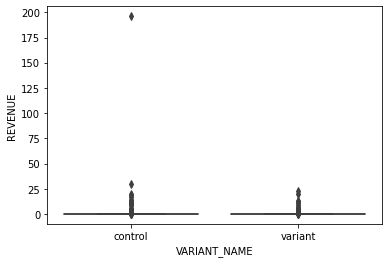

In [11]:
# Построим боксплот
sns.boxplot(x="VARIANT_NAME", y="REVENUE", data=df);

В контрольной группе заметен сильный выброс, уберем его из данных. Разобьем данные по группам на тестовую и контрольную выборки:

In [12]:
df = df[df.REVENUE < df.REVENUE.max()]

control = df[df.VARIANT_NAME == 'control'].REVENUE
test = df[df.VARIANT_NAME == 'variant'].REVENUE

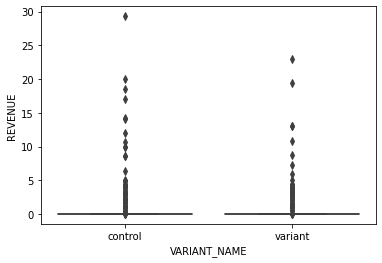

In [13]:
# Построим боксплот после чистки
sns.boxplot(x="VARIANT_NAME", y="REVENUE", data=df);

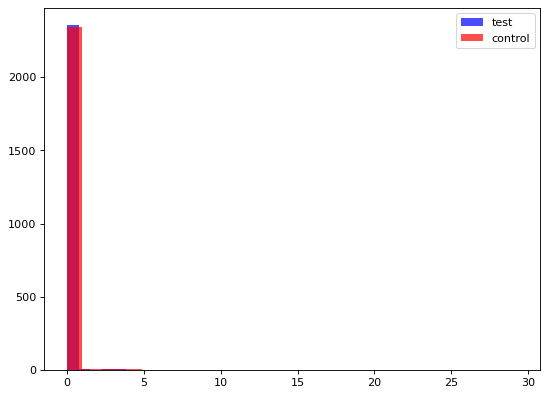

control len: 2389 
test len: 2393


In [14]:
# Построим гистограммы
figure(figsize=(8, 6), dpi=80);
plt.hist(test, bins=30, color='blue', alpha=0.7)
plt.hist(control, bins=30, color='red', alpha=0.7)
plt.legend(["test", "control"])
plt.show()

# Посчитаем размеры выборок
print('control len:', len(control), '\ntest len:', len(test))

Данные распределены не нормально. Значит для сравнения групп можно воспользоваться непараметрическим критерием Манна-Уитни или бутстрапом.

In [15]:
# Изучим описательные статистики двух групп
df.groupby('VARIANT_NAME').REVENUE.describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,2389.0,0.114923,1.162495,0.0,0.0,0.0,0.0,29.32
variant,2393.0,0.074935,0.858207,0.0,0.0,0.0,0.0,23.04


Проверим есть ли значимые различия между группами с помощью критерия Манна-Уитни. Гипотезы:
- H0: распределение дохода в тестовой группе соответствует распределению дохода в контрольной группе
- H1: значения дохода в тестовой выборке будут больше значений дохода в контрольной группе
- alpha = 0.05 (базовое общепринятое значение)

In [16]:
print('p-value:', st.mannwhitneyu(test.values, control.values, alternative='greater').pvalue)

p-value: 0.8760199648806348


**Результат:** по полученному значению p-value мы не можем отвергнуть H0 на выбранном уровне значимости.

Проверим есть ли значимые различия между группами с помощью Бутстрепа. Гипотезы:
- H0: средние значения дохода в двух группах равны
- H1: средние значения дохода в тестовой группе больше
- alpha = 0.05 (базовое общепринятое значение)

In [17]:
def get_bootstrap_samples(data, n_samples):
    '''Генерирует заданное кол-во (n_samples) выборок, равных по размеру исходной выборке'''
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [18]:
def get_stat_intervals(stat, alpha):
    '''Для заданной выборки возвращает односторонний доверительный интервал [0, 1 - alpha]'''
    boundaries = np.percentile(stat, [0, 100* (1 - alpha)])
    return boundaries

In [19]:
np.random.seed(0)

test_bootstrap = list(map(np.sum, get_bootstrap_samples(test.values, 1000)))
control_bootstrap = list(map(np.sum, get_bootstrap_samples(control.values, 1000)))

test_bootstrap_mean = [x/len(test) for x in test_bootstrap]
control_bootstrap_mean = [x/len(control) for x in control_bootstrap]

diff = list(map(lambda x: x[0] - x[1], zip(test_bootstrap_mean, control_bootstrap_mean)))

print(f'Average diff: {sum(diff) / len(diff) :.2f} ')
print('99% confidence interval for the difference between revenue:',  get_stat_intervals(diff, 0.05))

Average diff: -0.04 
99% confidence interval for the difference between revenue: [-0.1300081   0.00810773]


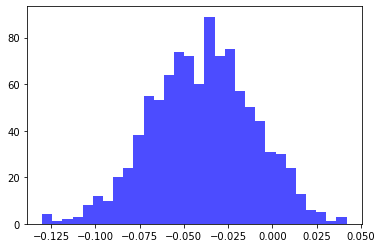

In [20]:
#Распределение разницы между средними
plt.hist(diff, bins=30, color='blue', alpha=0.7);

**Результат:** 0 попадает в доверительный интервал разницы между средними значениями дохода, а значит значимой разницы в средних доходах между группами не наблюдается.

### Рекомендации менеджеру:
- наблюдается проблема в разбиении пользователей на тестовую и контрольную группу (24% попали в обе группы сразу). Нужно разобраться, что могло пойти не так. В случае массовой проблемы в экспериментах чинить сплитовалку, в случае неправильного дизайна конкретного эксперимента - подумать о перезапуске.
- если не обнаружили никаких проблем и решили подводить результаты теста на очищенных данных, стоит проверить группы в АА тесте (до запуска эксперимента между группами не должно быть различий).
- по результатам проверки мы не обнаружили значимой разницы в доходах между группами. Внесенные изменения никак не повлияли на доходы и пользователи не стали больше платить.
- возможно, стоит посмотреть на дополнительные метрики, чтобы понять как повлияло изменение на пользователей (ради новых знаний, которые могут в дальнейшем повлиять на новые гипотезы).
- отмечу, что рекомеднации давать сложнее, когда нет информации об изменении в продукте (макеты от дизайна).